In [11]:
import os
import pandas as pd
import re
from collections import defaultdict
from datasets import Dataset

from parser import clean, get_resume_sections

df = pd.read_csv("UpdatedResumeDataSet.csv", encoding="utf-8")
df.drop_duplicates(subset=["Resume"], keep="first", inplace=True)
df.reset_index(inplace=True, drop=True)
df["Clean"] = df["Resume"].apply(clean)

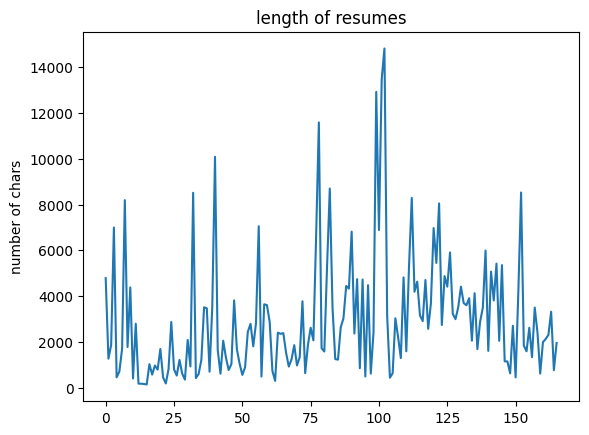

In [12]:
import matplotlib.pyplot as plt

lengths = []
for row in df["Clean"]:
    lengths.append(len(row))

plt.plot(lengths)
plt.title("length of resumes")
plt.ylabel("number of chars")
plt.show()



In [13]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import numpy as np

model_name = "thenlper/gte-base"
embedding_model = HuggingFaceEmbeddings(model_name=model_name)
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len
)

To test this, reduce chunk_size and chunk_overlap from earlier

In [14]:
text = "hello there my guy you are such a guy dude guy yaya yaya"

def chunk_data(text):
    docs = splitter.create_documents(texts=[text])
    return [doc.page_content for doc in docs]

def embed_chunks(chunks):
    return embedding_model.embed_documents(chunks)

chunks = chunk_data(text)
print(chunks)
embedded = embed_chunks(chunks)
print(embedded)
    

['hello there my guy you are such a guy dude guy yaya yaya']
[[-0.0012242910452187061, -0.012970250099897385, 0.009754830971360207, 0.019019102677702904, 0.026360496878623962, 0.010024252347648144, 0.05536678060889244, 0.06483981758356094, -0.0386713482439518, -0.0584564134478569, -0.014085439965128899, 0.011918534524738789, -0.04137302190065384, 0.004030672367662191, -0.015703285112977028, 0.07356765866279602, 0.07172895222902298, 0.0019875038415193558, 0.02538573183119297, 0.005252043250948191, -0.004389501642435789, 0.0007695987587794662, 0.02632075361907482, 0.0071949721314013, 0.014643811620771885, -0.013764429837465286, -0.033641934394836426, 0.04402585327625275, -0.07076282799243927, -0.022726763039827347, 0.03516467288136482, 0.0017697378061711788, 0.012717221863567829, -0.039876971393823624, -0.04122529551386833, -0.020886102691292763, -0.010542168281972408, 0.006501937285065651, 0.005712850950658321, -0.01801019161939621, -0.022091932594776154, -0.013020866550505161, -0.02783

In [15]:
df = df[:5]
df["Chunks"] = df["Clean"].apply(chunk_data)
df["Embeddings"] = df["Chunks"].apply(embed_chunks)
df

,Category,Resume,Clean,Chunks,Embeddings
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills * Programming Languages: Python (pandas...,[Skills * Programming Languages: Python (panda...,"[[0.01287016086280346, -0.01536303386092186, 0..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details \r\nMay 2013 to May 2017 B.E...,[Education Details \r\nMay 2013 to May 2017 B....,"[[0.02041388303041458, -0.019160525873303413, ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","Areas of Interest Deep Learning, Control Syste...","[Areas of Interest Deep Learning, Control Syst...","[[0.02442571334540844, 0.01927502639591694, -0..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Table...,[Skills R Python SAP HANA Tabl...,"[[0.007373979315161705, 0.012433757074177265, ..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","Education Details \r\n MCA YMCAUST, Faridab...","[Education Details \r\n MCA YMCAUST, Farida...","[[0.02551179751753807, -0.03329223394393921, 0..."


Embedding lengths are determined by model, so all will be the same

In [16]:
example = df["Embeddings"][0]
lengths = set([len(x) for x in example])
print(lengths)
EMBEDDING_LENGTH = list(lengths)[0]

{768}


Download postgres and run service


#### Statements to understand
```sql
CREATE TABLE name(
    val1 type1,
    val2 type2,
    val3 type3
)   
```
Create a table called name where each row (or record) keeps information on keys val1... with type type1...
```sql
INSERT INTO name (val1, val2, val3) VALUES (input1, input2, input3)
```
Insert the new record where val1 = input1, etc
```sql
SELECT * FROM name
```
Get every column of data for every row of name

In [17]:
from random import randint
import psycopg
from pgvector.psycopg import register_vector


TABLE_NAME = "resume_docs"

def load_db(df):
    with psycopg.connect("user=postgres") as conn:
        conn.execute('CREATE EXTENSION IF NOT EXISTS vector')
        register_vector(conn)
        with conn.cursor() as cur:
            cur.execute(f"DROP TABLE IF EXISTS {TABLE_NAME}")
            cur.execute(
                f"""
                CREATE TABLE {TABLE_NAME}(
                    id serial PRIMARY KEY,
                    source_id integer,
                    chunk text,
                    embedding vector({EMBEDDING_LENGTH})
                )   
                """
            )

            for i, row in df.iterrows():
                embeds = row["Embeddings"]
                chunks = row["Chunks"]
                for j in range(len(embeds)):
                    cur.execute(
                        f"INSERT INTO {TABLE_NAME} (source_id, chunk, embedding) VALUES (%s, %s, %s)", 
                        (i, chunks[j], embeds[j])
                    )

            for x in cur.execute(f"SELECT id, source_id FROM {TABLE_NAME}"):
                print(x)

load_db(df)

(1, 0)
(2, 0)
(3, 0)
(4, 0)
(5, 0)
(6, 0)
(7, 0)
(8, 0)
(9, 0)
(10, 0)
(11, 0)
(12, 0)
(13, 0)
(14, 0)
(15, 0)
(16, 0)
(17, 0)
(18, 0)
(19, 0)
(20, 0)
(21, 0)
(22, 1)
(23, 1)
(24, 1)
(25, 1)
(26, 1)
(27, 1)
(54, 3)
(28, 2)
(29, 2)
(30, 2)
(31, 2)
(32, 2)
(33, 2)
(34, 2)
(35, 2)
(36, 3)
(37, 3)
(38, 3)
(39, 3)
(40, 3)
(41, 3)
(42, 3)
(43, 3)
(44, 3)
(45, 3)
(46, 3)
(47, 3)
(48, 3)
(49, 3)
(50, 3)
(51, 3)
(52, 3)
(53, 3)
(55, 3)
(56, 3)
(57, 3)
(58, 3)
(59, 3)
(60, 3)
(61, 3)
(62, 3)
(63, 3)
(64, 3)
(65, 4)
(66, 4)


#### Selecting top K for SQL

General form:
```sql
SELECT * FROM table_name ORDER BY expression LIMIT k
```
Sort table_name by some some expression eg. (arg1, |arg1 - input|). Take just the top K


For our use case, it will look like this:

```sql
SELECT * FROM resume_docs ORDER BY embedding <-> query::vector LIMIT k
```
Where we order by embedding <-> query::vector where <-> gets cosine similarity from each rows embedding to our query embedding, which we explicitly cast to vector with ::vector. Then we take k closest

This is how we embed our query

In [18]:
query = "give me someone with software engineering experience"
query = embedding_model.embed_query(query)
print(query)
print(len(query))

[0.022511716932058334, 0.034850720316171646, -0.03828651085495949, 0.028686335310339928, 0.0669453889131546, 0.0016157837817445397, 0.04721405357122421, 0.021688176319003105, 0.0028032411355525255, -0.053106244653463364, -0.012069936841726303, 0.02490764856338501, -0.06599428504705429, 0.01332907471805811, -0.018487323075532913, 0.05695062130689621, 0.04884261637926102, 0.0019117322517558932, 0.028288085013628006, -0.004699026234447956, -0.010423772037029266, 0.025054506957530975, -0.007783595472574234, -0.001280068070627749, -0.0076367734000086784, -0.02998163551092148, 0.00016355358820874244, -0.006825693883001804, -0.056745629757642746, -0.002807231619954109, 0.028862647712230682, -0.021203989163041115, -0.025889737531542778, -0.050031911581754684, -0.06968700140714645, 0.017646677792072296, 0.015790777280926704, -0.0005512829520739615, -0.0073262471705675125, -0.022412706166505814, -0.028180953115224838, -0.013895634561777115, -0.011107447557151318, -0.0037797573022544384, -0.05250

In [70]:
def get_top_k(prompt, k):
    prompt = embedding_model.embed_query(prompt)
    with psycopg.connect("user=postgres") as conn:
        with conn.cursor() as cur:
            res = cur.execute(f"SELECT *, embedding <-> %s::vector AS similarity FROM {TABLE_NAME} ORDER BY similarity LIMIT %s", (prompt, k)).fetchall()
            return [
                {
                "score": record[4],
                "source_id": record[1]
                } 
                for record in res
            ]

query = "experience with machine learning and data analytics"
k = 10
res = get_top_k(query, k)
print(res)

[{'score': 0.5082399476629182, 'source_id': 0}, {'score': 0.5308704422785862, 'source_id': 3}, {'score': 0.5453195249001171, 'source_id': 2}, {'score': 0.5541676785404843, 'source_id': 1}, {'score': 0.5551582004846762, 'source_id': 1}, {'score': 0.556247317918462, 'source_id': 1}, {'score': 0.5617041786224501, 'source_id': 0}, {'score': 0.566937953393263, 'source_id': 3}, {'score': 0.5685181805531071, 'source_id': 0}, {'score': 0.5711294880551024, 'source_id': 0}]


In [77]:
from typing import List
# these 
def load_resumes(ids: List[int]):
    ids = list(set(ids))
    data = ""
    for id in ids:
        add = f"### Applicant ID {id}\n{df["Clean"][id]}\n\n"
        data += add
    return data

ids = [vals["source_id"] for vals in res]
print(load_resumes(ids))

### Applicant ID 0
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, Na  ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details 

Data Science Assurance Associate 

Data Science Assurance Associate - Ernst & Young LLP
Skill Details 
JAVASCRIPT- Exprience - 24 months
jQuery- Exprience - 24 months
Python- Exprience - 24 monthsCompany Details 
company - Ernst & Young LLP
description - Fraud Investigations and Dispu

In [23]:
from openai import OpenAI
from dotenv import load_dotenv
import os
load_dotenv()
# print(os.environ["OPENAI_API_KEY"])

True

Calling openai sdk which deepseek and other non open ai models also use

In [26]:
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user", 
            "content": "write a haiku about ai"
        }, # task or main prompt
        {
            "role": "developer", 
            "content": """You are a helpful assistant
                        that answers programming
                        questions in the style of a
                        southern belle from the
                        southeast United States."""
        }, # personality 
        {
            "role": "assistant", 
            "content": """Bits dance in the night,
                        logic weaves through lines of code,
                        dreams compile to life."""
        }, # reference responses 
    ],
    temperature=0, # how creative where 0 is deterministic
)

In [27]:
print(completion)
print(completion.choices)
print(completion.choices[0])
print(completion.choices[0].message)

print()
print(completion.choices[0].message.content)

ChatCompletion(id='chatcmpl-B6o5DwlOJ8IzSB7MuUwNDQMuBfcSp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Whispers of the code,  \nA mind born from circuits bright,  \nFuture's gentle hand.  ", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1740962187, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_06737a9306', usage=CompletionUsage(completion_tokens=22, prompt_tokens=72, total_tokens=94, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))
[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Whispers of the code,  \nA mind born from circuits bright,  \nFuture's gentle hand.  ", refusal=None, role='assistant', audio=None, f

In [81]:

def query(prompt):
    k = 10
    top_k = get_top_k(prompt, 10)
    ids = [vals["source_id"] for vals in top_k]
    context = load_resumes(ids)
    developer_prompt = "You are an expert in talent acquisition and tasked with analyzing and comparing a set resumes to select the best applicants for hire"
    query_prompt = f"""## Context:\n{context}\n\n## Query: {prompt}"""

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user", 
                "content":  query_prompt
            }, # task or main prompt
            {
                "role": "developer", 
                "content": developer_prompt
            }, # personality 
        ],
        temperature=0, # how creative where 0 is deterministic
    )
    return completion.choices[0].message.content

prompt = "give me applicants for with the most machine learning and data analytics experience and explain why"
res = query(prompt)



In [82]:
print(res)

Based on the provided applicant profiles, the candidates with the most machine learning and data analytics experience are:

### Applicant ID 0
- **Experience**: 24 months in Python, JavaScript, and jQuery, with extensive experience in machine learning techniques such as Regression, SVM, Naive Bayes, KNN, Random Forest, Decision Trees, and more. 
- **Projects**: Developed an automated review platform tool for e-discovery, which involved predictive coding and topic modeling. Worked on multiple data science projects, including text analytics and chatbot development, showcasing a strong grasp of natural language processing and sentiment analysis.
- **Tools**: Proficient in a wide range of tools and technologies, including Python libraries (scikit-learn, tfidf, word2vec), Tableau for visualization, and ElasticSearch for data indexing.

### Applicant ID 3
- **Experience**: Has experience in machine learning, deep learning, and data analytics through various consulting roles at Deloitte and A